In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
from lsst.source.injection import VisitInjectConfig, VisitInjectTask
from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
from lsst.pipe.tasks.coaddBase import makeSkyInfo

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.makeWarp import MakeWarpTask, MakeWarpConfig
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

import lsst.sphgeom as sphgeom

from lsst.ctrl.mpexec import pipeline2dot
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument

In [2]:
!pwd

/pscratch/sd/t/taceroc/LE_inj


In [3]:
# repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run2.2i/repo/butler-schema-migration.yaml'
# butler = dafPersist.Butler(repo)

# Define repo and collections

I followed some documentation:

https://github.com/LSSTDESC/ComputingInfrastructure/issues/62

https://confluence.slac.stanford.edu/spaces/LSSTDESC/pages/388840402/DC2+Data+with+the+Gen3+Butler

In [7]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# # These are the collections containing the Y1 processed visit images, etc..
# # collections = ['u/descdm/sfp_ddf_visits_part_00',
# #                'u/descdm/sfp_ddf_visits_part_01',
# #               ]
# collections = ['u/jchiang8/coadds_ddf_y1-y2_4848',
#               'u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

## Load Butler that contain new coadd

In [27]:
my_collection_identifier = 'custom_coadd_test_7_3192025'
user = os.getenv("USER")
inputCollection = f"u/{user}/{my_collection_identifier}"
print('Name of new butler collection for my input: ', inputCollection)

Name of new butler collection for my input:  u/taceroc/custom_coadd_test_7_3192025


In [28]:
butler = Butler(repo, collections=inputCollection)

In [29]:
my_new_deepCoadd = butler.get('deepCoadd', dataId={'band': 'g', 'skymap': 'DC2', 'tract': 4848, 'patch': 36})

In [30]:
my_deepCoadd_inputs = my_new_deepCoadd.getInfo().getCoaddInputs()
my_deepCoadd_inputs.visits.asAstropy()

<Table length=414>
  id   bbox_min_x bbox_min_y ... goodpix        weight         filter 
          pix        pix     ...                                      
int64    int32      int32    ...  int32        float64         str32  
------ ---------- ---------- ... -------- ------------------ ---------
   250       3900      19900 ... 15825791  33.34109512731768 g_sim_1.4
   251       3900      19900 ... 15889094  33.37548581906761 g_sim_1.4
   252       3900      19900 ... 16000230 33.487032499596296 g_sim_1.4
   253       3900      19900 ... 15846069 33.143288256165036 g_sim_1.4
   254       3900      19900 ... 15848086  33.41543649197798 g_sim_1.4
   255       3900      19900 ... 15922713  32.50640247154826 g_sim_1.4
   256       3900      19900 ... 15841215  32.17885599595723 g_sim_1.4
   257       3900      19900 ... 15839418  32.56178207178814 g_sim_1.4
   258       3900      19900 ... 15842369  32.38322286910422 g_sim_1.4
   ...        ...        ... ...      ...                ...       ...
637816       3900      19900 ...  4549150  30.89095359123575 g_sim_1.4
637848       3900      19900 ... 13106643 31.687697317957376 g_sim_1.4
637879       3900      19900 ...  8833738  32.51390231871094 g_sim_1.4
662586       3900      19900 ... 15545664  34.45661670866174 g_sim_1.4
662593       3900      19900 ... 16088598 34.639125148770034 g_sim_1.4
664578       3900      19900 ...  6745329 2.9755275381164457 g_sim_1.4
664579       3900      19900 ... 12073783  2.978136177495323 g_sim_1.4
664580       3900      19900 ...  5774544 2.9805308006106013 g_sim_1.4
664581       3900      19900 ...  6104749 2.9885859800962247 g_sim_1.4

In [34]:
from astropy.io import fits
firs = fits.open('/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo/u/descdm/sfp_ddf_visits_part_00/20220110T040559Z/visitSummary/20211231/g/g_sim_1.4/250/visitSummary_LSSTCam-imSim_g_g_sim_1_4_250_u_descdm_sfp_ddf_visits_part_00_20220110T040559Z.fits')

In [37]:
firs

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f099663a950>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996c5cbd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996662ed0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996d6b210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996dbaa50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996dba290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f0996de6b90>]

In [43]:
firs[2].data[0].get

(1, 1, 0, 0, 1, 'SkyWcs', 'lsst.afw.geom')

In [41]:
firs = fits.open('/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo/u/jchiang8/sfp_ddf_visits_part_03/20220411T182506Z/visitSummary/20231112/u/u_sim_1.4/466688/visitSummary_LSSTCam-imSim_u_u_sim_1_4_466688_u_jchiang8_sfp_ddf_visits_part_03_20220411T182506Z.fits')

In [ ]:
firs[2].data

In [42]:
firs[2].data

FITS_rec([(  1, 1, 0,  0, 1, 'SkyWcs', 'lsst.afw.geom'),
          (  3, 3, 0,  0, 1, 'ChebyshevBoundedField', 'lsst.afw.math'),
          (  2, 2, 0,  0, 1, 'PhotoCalib', ''),
          (  4, 4, 0,  0, 1, 'VisitInfo', ''),
          (  5, 1, 0,  1, 1, 'SkyWcs', 'lsst.afw.geom'),
          (  7, 3, 0,  1, 1, 'ChebyshevBoundedField', 'lsst.afw.math'),
          (  6, 2, 0,  1, 1, 'PhotoCalib', ''),
          (  8, 4, 0,  1, 1, 'VisitInfo', ''),
          (  9, 1, 0,  2, 1, 'SkyWcs', 'lsst.afw.geom'),
          ( 11, 3, 0,  2, 1, 'ChebyshevBoundedField', 'lsst.afw.math'),
          ( 10, 2, 0,  2, 1, 'PhotoCalib', ''),
          ( 12, 4, 0,  2, 1, 'VisitInfo', ''),
          ( 13, 1, 0,  3, 1, 'SkyWcs', 'lsst.afw.geom'),
          ( 15, 3, 0,  3, 1, 'ChebyshevBoundedField', 'lsst.afw.math'),
          ( 14, 2, 0,  3, 1, 'PhotoCalib', ''),
          ( 16, 4, 0,  3, 1, 'VisitInfo', ''),
          ( 17, 1, 0,  4, 1, 'SkyWcs', 'lsst.afw.geom'),
          ( 19, 3, 0,  4, 1, 'ChebyshevBoundedF

In [5]:
calexp_butler = Butler(repo, collections=collections)

In [6]:
#At the moment only tracts 35, 36, 42 and 43 in patch 4848 have 2-years depth coadds. We therefore limit the dataset query to this patch.
tract = 4848
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND band='g' and patch=35"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

Identified 1866 calexp DatasetRefs


In [7]:
calexp_g_DatasetRefs[10].dataId

{instrument: 'LSSTCam-imSim', detector: 8, visit: 195550, band: 'g', day_obs: 20220919, physical_filter: 'g_sim_1.4'}

In [8]:
calexp = calexp_butler.get('calexp', dataId=calexp_g_DatasetRefs[10].dataId)
bbox = calexp.getBBox()
wcs = calexp.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
center

SpherePoint(52.623862568391885*degrees, -28.57979666037756*degrees)

In [9]:
ra = center.getRa()
dec = center.getDec()

https://github.com/LSST-strong-lensing/DC2-notebooks/blob/main/Lensed_Transient_Single-Exposures.ipynb

# Load skymap contain this location, and extract deepcoadd for the same track and patch used for the calexp

## Following this https://pipelines.lsst.io/v/v27_0_0/modules/lsst.pipe.tasks/index.html#module-lsst.pipe.tasks.makeWarp

In [18]:
my_spherePoint = geom.SpherePoint(ra.asDegrees()*geom.degrees, dec.asDegrees()*geom.degrees)

skymap = calexp_butler.get('skyMap', skymap='DC2')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

My tract and patch:  4848 36


In [106]:
my_dataId = {'band': 'g', 'tract': 4848, 'patch': 36}
my_deepCoadd = calexp_butler.get('deepCoadd', dataId=my_dataId, skymap='DC2')

(3899.5, 8099.5, 19899.5, 24099.5)

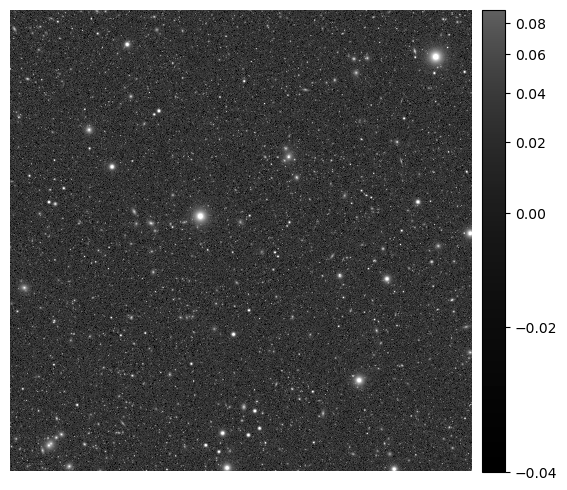

In [107]:
# wcs = my_new_deepCoadd.getWcs()
# center = wcs.skyToPixel(geom.SpherePoint(ra, dec))
fig = plt.figure(figsize=(10, 6))
afw_display2 = afwDisplay.Display(1)
afw_display2.scale('asinh', 'zscale')
afw_display2.mtv(my_deepCoadd.image)
# afw_display1.dot('+', center.x, center.y, size=20, ctype='orange')

plt.gca().axis('off')

In [20]:
my_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

In [21]:
len(my_coadd_inputs.visits)

413

In [22]:
help(my_coadd_inputs)

Help on CoaddInputs in module lsst.afw.image object:

class CoaddInputs(lsst.afw.typehandling.Storable)
 |  Method resolution order:
 |      CoaddInputs
 |      lsst.afw.typehandling.Storable
 |      lsst.afw.table.io.Persistable
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image.CoaddInputs) -> None
 |      
 |      2. __init__(self: lsst.afw.image.CoaddInputs, visitSchema: lsst.afw.table.Schema, ccdSchema: lsst.afw.table.Schema) -> None
 |      
 |      3. __init__(self: lsst.afw.image.CoaddInputs, visits: lsst.afw.table.ExposureCatalog, ccds: lsst.afw.table.ExposureCatalog) -> None
 |  
 |  isPersistable(...)
 |      isPersistable(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. isPersistable(self: lsst.afw.image.CoaddInputs) -> bool
 |      
 |      2. isPersistable(self: lsst.afw.image

## Load visittable

In [23]:
visitTableRef = list(calexp_butler.registry.queryDatasets('visitTable'))

In [24]:
len(visitTableRef)

4

In [25]:
visitTable = calexp_butler.get(visitTableRef[1])

## Concatenate all visit tables

In [26]:
visitTable = pd.DataFrame()
for v in visitTableRef:
    visitTable_uni = calexp_butler.get(v)
    visitTable_uni = visitTable_uni[visitTable_uni['physical_filter'] == 'g_sim_1.4']
    visitTable = pd.concat([visitTable,visitTable_uni])

In [27]:
visitTable

visit physical_filter band         ra       decl  skyRotation  \
visitId                                                                   
470418   470418       g_sim_1.4    g  53.025240 -27.359686   351.663325   
470419   470419       g_sim_1.4    g  53.081563 -27.409074   356.561703   
470420   470420       g_sim_1.4    g  52.970481 -27.439986   356.615431   
470421   470421       g_sim_1.4    g  52.989470 -27.519621   356.697734   
470422   470422       g_sim_1.4    g  53.058978 -27.354736   356.506490   
...         ...             ...  ...        ...        ...          ...   
457526   457526       g_sim_1.4    g  53.099851 -27.417630   267.213413   
457527   457527       g_sim_1.4    g  52.984977 -27.452781   267.277423   
457528   457528       g_sim_1.4    g  52.991489 -27.525345   267.375454   
457529   457529       g_sim_1.4    g  53.025332 -27.357239   267.140666   
457530   457530       g_sim_1.4    g  52.976891 -27.493027   267.333762   

           azimuth   altitude  zenithDistance   airmass  \
visitId                                                   
470418   98.375118  48.251144       41.748856  1.327753   
470419   98.412452  48.345057       41.654943  1.325919   
470420   98.362775  48.576990       41.423010  1.321438   
470421   98.431603  48.710474       41.289526  1.318873   
470422   98.161560  48.735408       41.264592  1.318412   
...            ...        ...             ...       ...   
457526   95.675511  54.705646       35.294354  1.219182   
457527   95.632982  54.942546       35.057454  1.215791   
457528   95.700634  55.084262       34.915738  1.213775   
457529   95.371180  55.142666       34.857334  1.212962   
457530   95.525261  55.347395       34.652605  1.210081   

                          obsStart  expTime  
visitId                                      
470418  2023-11-19 01:12:33.974199     30.0  
470419  2023-11-19 01:13:10.003100     30.0  
470420  2023-11-19 01:13:46.032000     30.0  
470421  2023-11-19 01:14:21.974200     30.0  
470422  2023-11-19 01:14:58.003100     30.0  
...                            ...      ...  
457526  2023-10-24 03:25:03.292900     30.0  
457527  2023-10-24 03:25:39.321800     30.0  
457528  2023-10-24 03:26:15.350200     30.0  
457529  2023-10-24 03:26:51.292899     30.0  
457530  2023-10-24 03:27:27.321800     30.0  

[430 rows x 12 columns]

# Keep the entries on visit table that have match on the coadd visits

In [28]:
my_coadd_visits_mjds = visitTable.loc[my_coadd_inputs.visits['id']]

In [29]:
my_coadd_visits_mjds.iloc[0]['obsStart']

Timestamp('2022-01-01 03:35:25.545800')

In [30]:
my_coadd_visits_mjds.iloc[0]['obsStart'].to_julian_date()

2459580.6496012243

## Convert time to MJD

In [31]:
my_coadd_visits_mjds.loc[:, 'mjd'] = my_coadd_visits_mjds.loc[:, 'obsStart'].map(lambda x: x.to_julian_date())

In [32]:
my_coadd_visits_mjds.loc[:, 'mjd'] = my_coadd_visits_mjds.loc[:, 'mjd'].map(lambda x: round(x,0))

In [33]:
my_coadd_visits_mjds.loc[:, 'mjd'].unique()

array([2459581., 2459824., 2459826., 2459840., 2459841., 2459843.,
       2459855., 2459858., 2459868., 2459871., 2459874., 2459885.,
       2459888., 2459897., 2459900., 2459903., 2459914., 2459917.,
       2459925., 2459928., 2459931., 2459933., 2459934., 2459943.,
       2459946., 2460145., 2460146., 2460179., 2460193., 2460196.,
       2460197., 2460210., 2460213., 2460224., 2460227., 2460228.,
       2460239., 2460242., 2460268., 2460271., 2460279., 2460280.,
       2460282., 2460285., 2460288., 2460298., 2460301., 2460502.,
       2460525., 2460531., 2460561., 2460568.])

# Select a initial range of mjd and extract visits for that range

In [34]:
my_range = np.array(( my_coadd_visits_mjds['mjd'] >= my_coadd_visits_mjds['mjd'].unique()[0])
                    & ( my_coadd_visits_mjds['mjd'] < my_coadd_visits_mjds['mjd'].unique()[1]))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)

(250,251,252,253,254,255,256,257,258,259)


In [35]:
my_ccds_inputs = my_coadd_inputs.ccds.asAstropy().to_pandas()

In [37]:
user = os.getenv("USER")
print(user)

taceroc


In [109]:
# my_coadd_visits_mjds['mjd'].unique()[0] - [1]
my_collection_identifier = 'custom_coadd_test_2_3192025'
print(my_collection_identifier)

custom_coadd_test_2_3192025


In [110]:
my_outputCollection = f"u/{user}/{my_collection_identifier}"
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/taceroc/custom_coadd_test_2_3192025


In [111]:
for c in sorted(calexp_butler.registry.queryCollections()):
    if c.find(my_outputCollection) > -1:
        print(c)

In [113]:
simpleButler = SimplePipelineExecutor.prep_butler(repo, 
                                                  inputs=collections, 
                                                  output=my_outputCollection)


# calexp_butler = Butler(repo, collections=collections)

In [114]:
simpleButler.registry.getCollectionChain(my_outputCollection)

('u/taceroc/custom_coadd_test_2_3192025/20250319T170305Z',
 'u/jchiang8/coadds_ddf_y1-y2_4848',
 'u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd')

# Create a pipeline with the makeWarp and assembleCoadd tasks


In [115]:
! echo $DRP_PIPE_DIR

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/drp_pipe/gfa69e0f95e+cb6a7025ff


In [116]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml'
# yaml_file = '$DRP_PIPE_DIR/pipelines/DECam/DRP-Merian.yaml'

steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#makeWarp,assembleCoadd


In [118]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

In [119]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 
                                        'connections.visitSummary', 
                                        "visitSummary")

In [120]:
# version issue
assembleCoaddPipeline.addConfigOverride('assembleCoadd', 'doSelectVisits', False)

In [85]:
pipeline2dot(assembleCoaddPipeline, "/global/homes/t/taceroc/custom_coadd_qgraph.dot")#'/homes/t/' + getpass.getuser())# + '/custom_coadd_qgraph.dot')

! dot -Tpng "/global/homes/t/taceroc/custom_coadd_qgraph.dot" > "/global/homes/t/taceroc/custom_coadd_qgraph.png"

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/obs_lsst/g5c5439fafc+141fc35c6f/config/assembleCoadd.py:28: FutureWarning: Config field doSigmaClip is deprecated: True
  config.doSigmaClip = False


In [121]:
queryString = f"tract = {4848} AND patch = {36} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

tract = 4848 AND patch = 36 AND visit in (250,251,252,253,254,255,256,257,258,259) AND skymap = 'DC2'


In [122]:
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, 
                                           where=queryString, 
                                           butler=simpleButler)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/obs_lsst/g5c5439fafc+141fc35c6f/config/assembleCoadd.py:28: FutureWarning: Config field doSigmaClip is deprecated: True
  config.doSigmaClip = False


In [123]:
quanta = spe.run()

In [124]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.pipe.tasks.makeWarp.MakeWarpTask
1 lsst.pipe.tasks.makeWarp.MakeWarpTask
2 lsst.pipe.tasks.makeWarp.MakeWarpTask
3 lsst.pipe.tasks.makeWarp.MakeWarpTask
4 lsst.pipe.tasks.makeWarp.MakeWarpTask
5 lsst.pipe.tasks.makeWarp.MakeWarpTask
6 lsst.pipe.tasks.makeWarp.MakeWarpTask
7 lsst.pipe.tasks.makeWarp.MakeWarpTask
8 lsst.pipe.tasks.makeWarp.MakeWarpTask
9 lsst.pipe.tasks.makeWarp.MakeWarpTask
10 lsst.drp.tasks.assemble_coadd.CompareWarpAssembleCoaddTask


In [125]:
for output in quanta[-1].outputs:
    print(output)

DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap)
DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF)
DatasetType('deepCoadd_nImage', {band, skymap, tract, patch}, ImageU)
DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, TaskMetadata)
DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords)


In [126]:
quanta[-1].outputs['deepCoadd']

(DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4848, patch: 36}, run='u/taceroc/custom_coadd_test_2_3192025/20250319T170305Z', id=999b3805-1e6c-4c11-98f3-30af8dcb11cd),)

In [127]:
# my_new_deepCoadd = simpleButler.get(quanta[-1].outputs['deepCoadd'][0])

In [128]:
simpleButler.registry.getCollectionChain(my_outputCollection)

('u/taceroc/custom_coadd_test_2_3192025/20250319T170305Z',
 'u/jchiang8/coadds_ddf_y1-y2_4848',
 'u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd')

In [133]:
my_new_deepCoadd = simpleButler.get('deepCoadd', dataId={'band': 'g', 'skymap': 'DC2', 'tract': 4848, 'patch': 36})

In [130]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

In [132]:
center

Point2D(6501.074257840075, 21696.716533009487)

(3899.5, 8099.5, 19899.5, 24099.5)

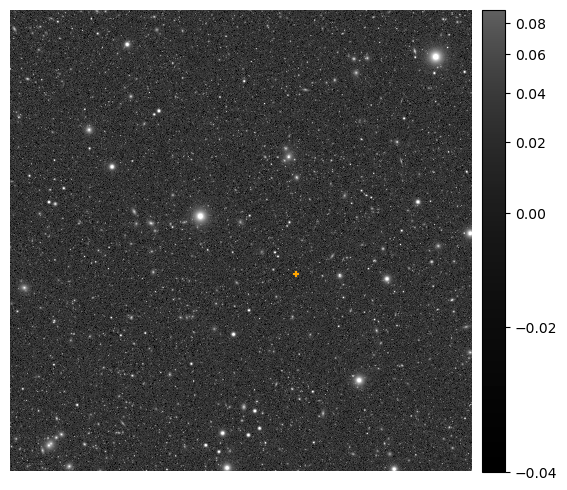

In [134]:
wcs = my_new_deepCoadd.getWcs()
center = wcs.skyToPixel(geom.SpherePoint(ra, dec))
fig = plt.figure(figsize=(10, 6))
afw_display1 = afwDisplay.Display(1)
afw_display1.scale('asinh', 'zscale')
afw_display1.mtv(my_new_deepCoadd.image)
afw_display1.dot('+', center.x, center.y, size=20, ctype='orange')

plt.gca().axis('off')

# Do same for the other mjd range

In [135]:
my_range = np.array(( my_coadd_visits_mjds['mjd'] >= my_coadd_visits_mjds['mjd'].unique()[3])
                    & ( my_coadd_visits_mjds['mjd'] < my_coadd_visits_mjds['mjd'].unique()[5]))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)


my_collection_identifier = 'custom_coadd_test_3_3192025'
print(my_collection_identifier)

my_outputCollection = f"u/{user}/{my_collection_identifier}"
print('Name of new butler collection for my output: ', my_outputCollection)

simpleButler = SimplePipelineExecutor.prep_butler(repo, 
                                                  inputs=collections, 
                                                  output=my_outputCollection)

yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml'
# yaml_file = '$DRP_PIPE_DIR/pipelines/DECam/DRP-Merian.yaml'

steps = 'makeWarp,assembleCoadd'
my_uri = yaml_file + '#' + steps
print(my_uri)

assembleCoaddPipeline = Pipeline.from_uri(my_uri)

assembleCoaddPipeline.addConfigOverride('makeWarp', 
                                        'connections.visitSummary', 
                                        "visitSummary")

assembleCoaddPipeline.addConfigOverride('assembleCoadd', 'doSelectVisits', False)

queryString = f"tract = {4848} AND patch = {36} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)


spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, 
                                           where=queryString, 
                                           butler=simpleButler)
quanta = spe.run()


(192915,192916,192917,192918,192919,192920,192921,192922,192923,192924,193784)
custom_coadd_test_3_3192025
Name of new butler collection for my output:  u/taceroc/custom_coadd_test_3_3192025
$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#makeWarp,assembleCoadd
tract = 4848 AND patch = 36 AND visit in (192915,192916,192917,192918,192919,192920,192921,192922,192923,192924,193784) AND skymap = 'DC2'


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/obs_lsst/g5c5439fafc+141fc35c6f/config/assembleCoadd.py:28: FutureWarning: Config field doSigmaClip is deprecated: True
  config.doSigmaClip = False


In [136]:
my_new_deepCoadd = simpleButler.get('deepCoadd', dataId={'band': 'g', 'skymap': 'DC2', 'tract': 4848, 'patch': 36})


(3899.5, 8099.5, 19899.5, 24099.5)

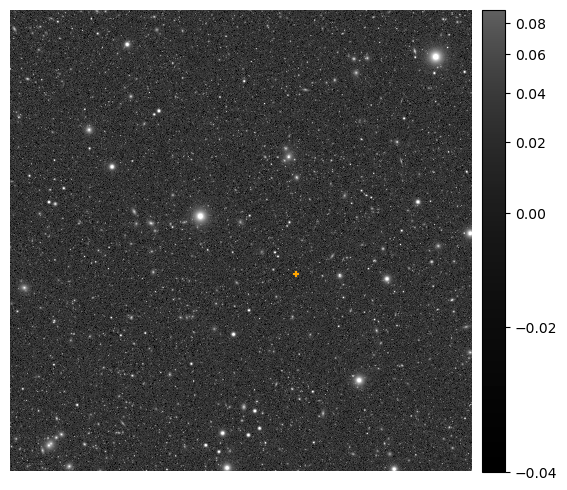

In [137]:
wcs = my_new_deepCoadd.getWcs()
center = wcs.skyToPixel(geom.SpherePoint(ra, dec))
fig = plt.figure(figsize=(10, 6))
afw_display1 = afwDisplay.Display(1)
afw_display1.scale('asinh', 'zscale')
afw_display1.mtv(my_new_deepCoadd.image)
afw_display1.dot('+', center.x, center.y, size=20, ctype='orange')

plt.gca().axis('off')

# End
--------------------------------------------------------------------------------

## Extract ccd, needed for the makewarp task

In [36]:
ccdsidlist = my_ccds_inputs[my_ccds_inputs['visit'].isin(my_visits['id'])]['ccd'].values

In [36]:
ccdsidlist

array([ 80,  87, 119, 126,  35,  74,  81,  35,  42,  74,  81,  74,  76,
        77,  81,  74,  77,  81,  84,  73,  74,  76,  77,  74,  77,  81,
        84,  74,  77,  81,  84,  74,  77,  81,  84,  74,  77,  81,  84],
      dtype=int32)

In [37]:
# my_dataId = {'band': 'g', 'tract': 4848, 'detector': 6, 'patch': 35, 'visit':250}
# calexps_makewrap = calexp_butler.get('calexp', dataId=my_dataId, skymap='DC2')

In [38]:
# datasetRefs_list_true

In [39]:
# datasetRefs_list_true[0]

## Make a list of the calexp that are in the same patch, visits, tract

use patch as in 

my_tract = tract.tract_id

my_patch = tract.findPatch

In [40]:
tract = 4848
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND band='g' and patch=36 and visit in {my_visits_tupleString}"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

Identified 43 calexp DatasetRefs


In [42]:
calexplist = []
for c in calexp_g_DatasetRefs:
    my_calexp_t = calexp_butler.get('calexp', dataId=c.dataId)
    calexplist.append(my_calexp_t)

# Start make warp task

In [43]:
config = MakeWarpConfig()
warpTask = MakeWarpTask(config=config)

result = warpTask.run(calExpList=calexplist, ccdIdList=ccdsidlist, skyInfo=makeSkyInfo(skymap, 4848, 36))

In [44]:
result

Struct(exposures={'direct': <lsst.afw.image._exposure.ExposureF object at 0x7f5c59ce3330>})

In [45]:
wcs = result.exposures['direct'].getWcs()
center = wcs.skyToPixel(geom.SpherePoint(ra, dec))

In [46]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

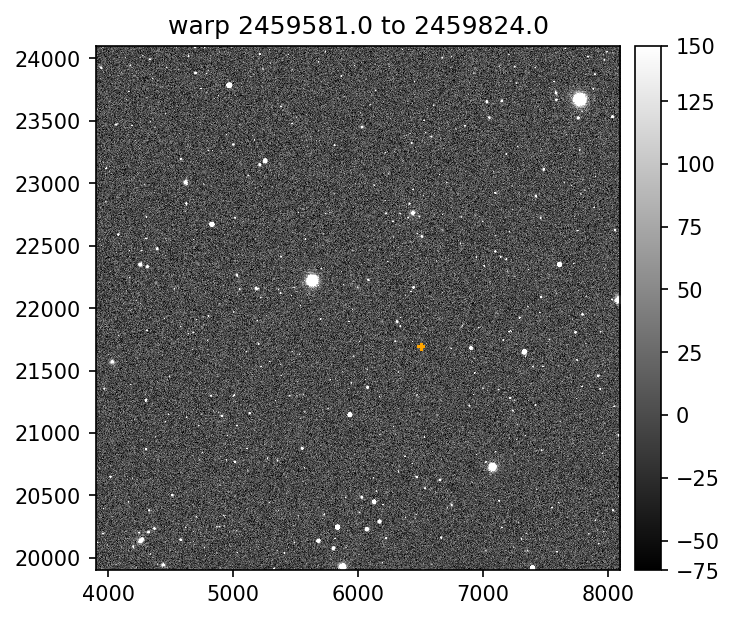

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result.exposures['direct'].image)

display2.dot('+', center.x, center.y, size=20, ctype='orange')
# To zoom on the PGC 038749 stamp:
# display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title(f"warp {my_coadd_visits_mjds['mjd'].unique()[0]} to {my_coadd_visits_mjds['mjd'].unique()[1]}")

plt.tight_layout()
plt.show()

# Do the same for another MJDs

In [49]:
my_range = np.array(( my_coadd_visits_mjds['mjd'] >= my_coadd_visits_mjds['mjd'].unique()[3])
                    & ( my_coadd_visits_mjds['mjd'] < my_coadd_visits_mjds['mjd'].unique()[5]))
my_visits = my_coadd_inputs.visits[my_range]
my_visits_tupleString = "("+",".join(my_visits['id'].astype(str))+")"
print(my_visits_tupleString)
ccdsidlist = my_ccds_inputs[my_ccds_inputs['visit'].isin(my_visits['id'])]['ccd'].values

tract = 4848
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          tract={tract} AND band='g' and patch=36 and visit in {my_visits_tupleString}"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

calexplist = []
for c in calexp_g_DatasetRefs:
    my_calexp_t = calexp_butler.get('calexp', dataId=c.dataId)
    calexplist.append(my_calexp_t)

(192915,192916,192917,192918,192919,192920,192921,192922,192923,192924,193784)
Identified 50 calexp DatasetRefs


In [50]:
config = MakeWarpConfig()
warpTask = MakeWarpTask(config=config)
result = warpTask.run(calExpList=calexplist, ccdIdList=ccdsidlist, skyInfo=makeSkyInfo(skymap, 4848, 36))

In [51]:
wcs = result.exposures['direct'].getWcs()
center = wcs.skyToPixel(geom.SpherePoint(ra, dec))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


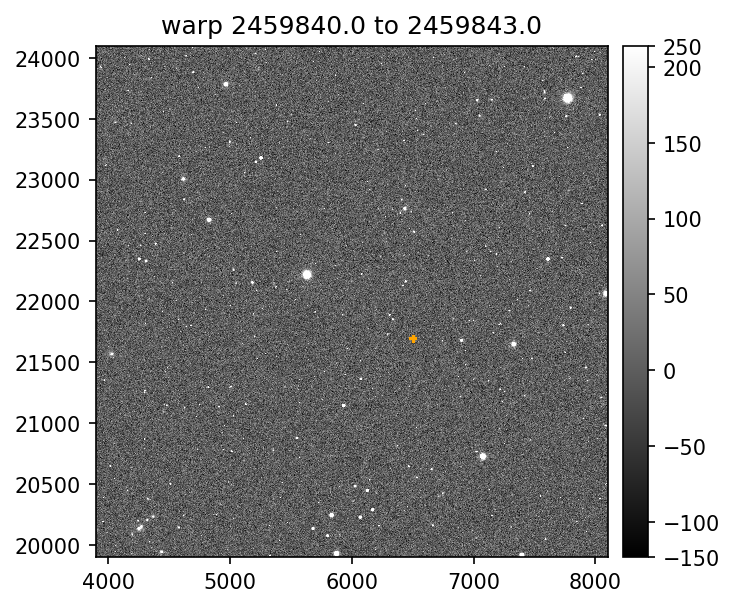

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

display3 = afwDisplay.Display(frame=fig)
display3.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display3.mtv(result.exposures['direct'].image)

display3.dot('+', center.x, center.y, size=20, ctype='orange')
# To zoom on the PGC 038749 stamp:
# display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title(f"warp {my_coadd_visits_mjds['mjd'].unique()[3]} to {my_coadd_visits_mjds['mjd'].unique()[5]}")

plt.tight_layout()
plt.show()

# To do DIA you need to do source detection first ....
# To do source detection, do you need the coadd?

march 19: Apparently yes, I need the coadd. Soooo, new notebook where I tried the pipeline as in the dp0 tutorial

NOTE: if the pipeline ended beeing more convenient, I think it is better to submit the pipeline on the command and no

In [ ]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


sources = calexp_butler.get('src', dataId=dataId)
result = alTask.run(calexp, calexp, sources)

fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display1.mtv(calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(calexp.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

In [130]:
datasetRefs_list_true[0]

DatasetRef(DatasetType('calexp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 7, visit: 204407, band: 'g', day_obs: 20221004, physical_filter: 'g_sim_1.4'}, run='u/descdm/sfp_ddf_visits_part_00/20220110T040559Z', id=7c319485-3a03-40af-8753-7f5f242743e0)

In [32]:

# circle = lsst.sphgeom.from_ivoa_pos(f"CIRCLE {RA} {DEC} {1}")
# circle = "POINT('ICRS', " + target_str_ra + \
#         ", " + target_str_dec + "), s_region) = 1"
datasetRefs = calexp_butler.registry.queryDatasets("calexp", where="visit_detector_region.region OVERLAPS myregion AND band = 'g'",
                                    bind={"ra": ra.asDegrees(), "dec": dec.asDegrees(), 'myregion': circle})

# datasetRefs = calexp_butler.registry.queryDatasets("calexp", where="band = 'g'",
#                                     bind={"ra": ra.asDegrees(), "dec": dec.asDegrees()})
# https://community.lsst.org/t/issue-with-calexps-retrieval-using-overlaps-method-some-calexps-not-intersecting-the-region/9785
print(datasetRefs)

NameError: name 'circle' is not defined

In [228]:

for ref in datasetRefs:
    print(ref)

calexp@{instrument: 'LSSTCam-imSim', detector: 139, visit: 242014, band: 'g', day_obs: 20221129, physical_filter: 'g_sim_1.4'} [sc=ExposureF] (run=u/descdm/sfp_ddf_visits_part_01/20220311T204642Z id=6f9b7636-ae79-4a40-8d25-40ba3e61adfc)
calexp@{instrument: 'LSSTCam-imSim', detector: 99, visit: 250887, band: 'g', day_obs: 20221213, physical_filter: 'g_sim_1.4'} [sc=ExposureF] (run=u/descdm/sfp_ddf_visits_part_01/20220311T204642Z id=899c061b-921a-4283-b0a0-572b6b97c072)
calexp@{instrument: 'LSSTCam-imSim', detector: 100, visit: 250887, band: 'g', day_obs: 20221213, physical_filter: 'g_sim_1.4'} [sc=ExposureF] (run=u/descdm/sfp_ddf_visits_part_01/20220311T204642Z id=fb8bdcb3-fcae-40e8-a65e-07ced7c410ec)
calexp@{instrument: 'LSSTCam-imSim', detector: 97, visit: 250887, band: 'g', day_obs: 20221213, physical_filter: 'g_sim_1.4'} [sc=ExposureF] (run=u/descdm/sfp_ddf_visits_part_01/20220311T204642Z id=fb95fcfb-8e95-481a-bf4d-2c77a7966944)
calexp@{instrument: 'LSSTCam-imSim', detector: 94, vis

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [205]:
calexp_butler.query_dimension_records('detector', where="instrument='LSSTCam-imSim' "
                               "AND detector.id IN (6..8)")

AttributeError: 'DirectButler' object has no attribute 'query_dimension_records'

In [172]:
calexp_t1 = calexp_butler.get('calexp', dataId=calexp_g_DatasetRefs[0].dataId)
bbox = calexp_t1.getBBox()
wcs = calexp_t1.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
center

SpherePoint(52.8349931616329*degrees, -28.7234862506169*degrees)

In [169]:
unique_dates = np.unique([x.dataId['day_obs'] for idx, x in enumerate(calexp_g_DatasetRefs)])

In [170]:
unique_dates

array([20220919, 20221218, 20231005, 20231129, 20231208])

In [84]:
# tract = 4848
# where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
#           tract={tract} AND band='g' AND patch=35 AND day_obs=20221031"
# calexp_g_DatasetRefs_t2 = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
# print(f'Identified {len(calexp_g_DatasetRefs_t2)} calexp DatasetRefs')

# where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
#           tract={tract} AND band='g' AND patch=35 AND day_obs=20220831"
# calexp_g_DatasetRefs_t1 = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
# print(f'Identified {len(calexp_g_DatasetRefs_t1)} calexp DatasetRefs')

In [85]:
# calexp_t2 = calexp_butler.get('calexp', dataId=calexp_g_DatasetRefs_t2[0].dataId)
# bbox = calexp_t2.getBBox()
# wcs = calexp_t2.getWcs()
# center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
# # c = SkyCoord(ra=center.getRa().asDegrees()*u.degree,
# #              dec=center.getDec().asDegrees()*u.degree, frame='icrs')
# print(center)
# calexp_t1 = calexp_butler.get('calexp', dataId=calexp_g_DatasetRefs_t1[0].dataId)
# bbox = calexp_t1.getBBox()
# wcs = calexp_t1.getWcs()
# center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
# print(center)

In [23]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

Text(0.5, 1.0, 'calexp t2 image')

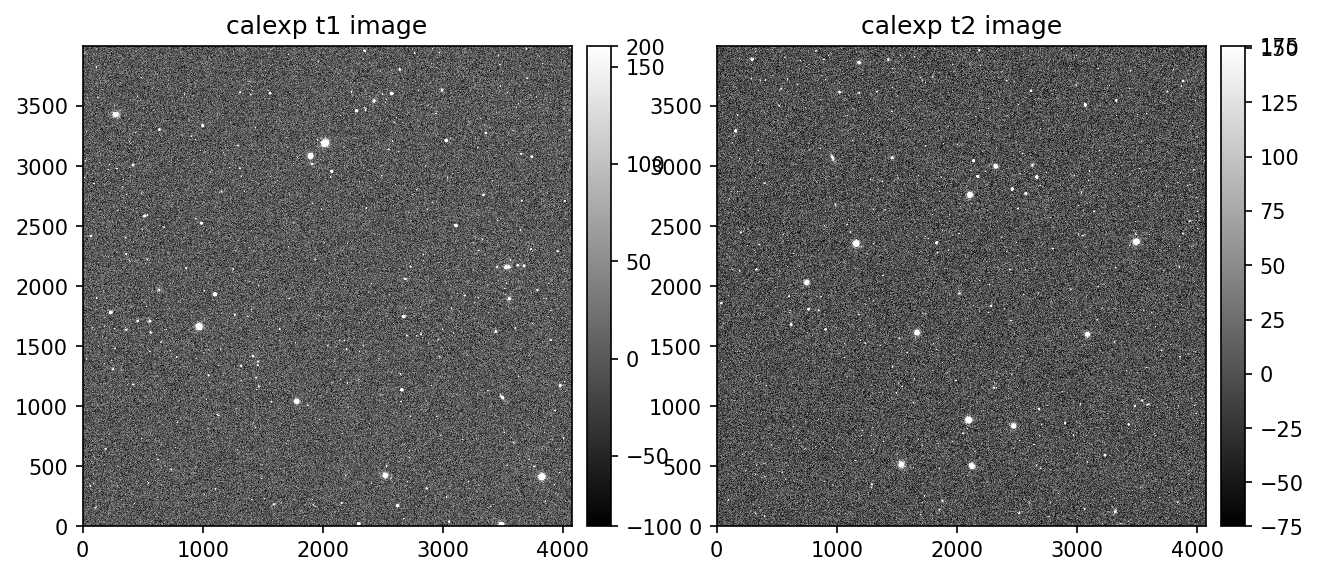

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(calexp_t1.image)#[3510:3560, 1750:1800])
plt.title('calexp t1 image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)

display1.mtv(calexp_t2.image)#[3510:3560, 1750:1800])
plt.title('calexp t2 image')

## Select a dataset id

# Plot LE fits

In [174]:
stamp_img_hdu_165 = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img_165 = stamp_img_hdu_165[0].data
stamp_img_hdu_165.close()

stamp_img_hdu_230 = fits.open('fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits')
fits_img_230 = stamp_img_hdu_230[0].data
stamp_img_hdu_230.close()

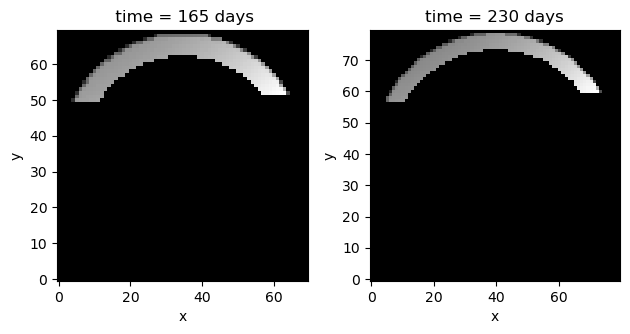

In [175]:
fig = plt.figure()
plt.subplot(121)
im = plt.imshow(fits_img_165, cmap='gray', origin='lower')
plt.title(" time = 165 days")
# plt.colorbar(im)
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(122)
im = plt.imshow(fits_img_230, cmap='gray', origin='lower')
# plt.colorbar(im)
plt.title("time = 230 days")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

In [176]:
# stamp_img_hdu_med = fits.open('output_file1_median.fits')
# fig = plt.figure()
# plt.subplot()
# im = plt.imshow(stamp_img_hdu_med[0].data, cmap='gray', origin='lower')
# plt.colorbar(im)
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

In [178]:
calexp_t1.getWcs()

FITS standard SkyWcs:
Sky Origin: (52.8313207163, -28.7187749683)
Pixel Origin: (2133.32, 2031.1)
Pixel Scale: 0.1999 arcsec/pixel

In [179]:
calexp_t1.getBBox()

Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000))

In [21]:
# calexp.containsSkyCoords(53.132*u.deg, -28.398*u.deg)

In [22]:
# help(calexp.getWcs())

## Define location of LE injection on calexp

Use pixel location, then convert to radec

check that calexp contain the location

In [189]:
radec = calexp_t1.getWcs().pixelToSky(geom.Point2D(1300,100))

In [192]:
radec

SpherePoint(52.79807052307496*degrees, -28.83176151907268*degrees)

In [190]:
calexp_t1.containsSkyCoords(radec.getRa().asAngularUnits(geom.degrees)*u.deg, radec.getDec().asAngularUnits(geom.degrees)*u.deg)

array([ True])

In [191]:
calexp_t2.containsSkyCoords(radec.getRa().asAngularUnits(geom.degrees)*u.deg, radec.getDec().asAngularUnits(geom.degrees)*u.deg)

array([False])

In [25]:
# radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
# xy = calexp.getWcs().skyToPixel(radec)

# Create injection catalog

I followed DP02_14_Injecting_Synthetic_Sources.ipynb

In [26]:
def create_table_catalog(ids, ra, dec, mag, path_stamp):
    
    my_injection_catalog_stamp = Table(
    {
        'injection_id': [ids],
        'ra': [ra],
        'dec': [dec],
        'source_type': ['Stamp'],
        'mag': [mag],
        'stamp': [path_stamp],
    }
)
    return my_injection_catalog_stamp

In [27]:
path_stamps_165 = 'fits/surface_valuesInfPlane_dt0_loop_ct165_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'
path_stamps_230 = 'fits/surface_valuesInfPlane_dt0_loop_ct230_loc[0.9, -1.3, 1, -32.6156]_dz0.06_w673_angle[30, 155].fits'
mag = 24
ids = 0
ra = round(radec.getRa().asAngularUnits(geom.degrees),2)
dec = round(radec.getDec().asAngularUnits(geom.degrees),2)

In [28]:
my_injection_catalog_stamp = create_table_catalog(ids, ra, dec, mag, path_stamps_165)

In [29]:
os.getenv("USER")

'taceroc'

In [30]:
# !butler remove-runs /global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo u/taceroc/test_LEinjection_inputs

## Name the injection catalog collection

In [31]:
user = os.getenv("USER")
# butler remove-runs dp02 u/taceroc/test_LEinjection_inputs_2
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_3132025_165"

In [49]:
# Butler(repo, writeable=True).removeRuns(names=['u/taceroc/test_LEinjection_inputs'])

In [33]:
writeable_butler = Butler(repo, writeable=True)

In [34]:
# help(Butler)

## Ingest catalog

In [35]:
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

In [36]:
psf = calexp.getPsf()
photo_calib = calexp.getPhotoCalib()
wcs = calexp.getWcs()

# Inject catalogs

In [37]:
injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]

In [38]:
radec = geom.SpherePoint(my_injection_catalog_stamp["ra"], my_injection_catalog_stamp["dec"], geom.degrees)
xy = calexp.getWcs().skyToPixel(radec)

In [39]:
xy

Point2D(118.5837764614871, 206.84428983567045)

In [40]:
inject_config = VisitInjectConfig()

inject_task = VisitInjectTask(config=inject_config)

In [41]:
injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog

In [43]:
xy

Point2D(118.5837764614871, 206.84428983567045)

# Need to inject in the same calexp? but different LEs

In [44]:
my_injection_catalog_stamp = create_table_catalog(ids, ra, dec, mag, path_stamps_230)
INJECTION_CATALOG_COLLECTION = f"u/{user}/test_LEinjection_inputs_3132025_230"
writeable_butler = Butler(repo, writeable=True)
try:
    my_injected_datasetRefs = ingest_injection_catalog(
        writeable_butler=writeable_butler,
        table=my_injection_catalog_stamp,
        band=dataId["band"],
        output_collection=INJECTION_CATALOG_COLLECTION,
    )
except ConflictingDefinitionError:
    print(f"Found an existing collection named INJECTION_CATALOG_COLLECTION={INJECTION_CATALOG_COLLECTION}.")
    print("\nNOTE THAT IF YOU SEE THIS MESSAGE, YOUR CATALOG WAS NOT INGESTED."
          "\nYou may either continue with the pre-existing catalog, or choose a new"
          " name and re-run the previous cell and this one to ingest a new catalog.")

injection_refs = calexp_butler.registry.queryDatasets(
    "injection_catalog",
    band=dataId["band"],
    collections=INJECTION_CATALOG_COLLECTION,
)
injection_catalogs = [
    calexp_butler.get(injection_ref) for injection_ref in injection_refs
]


inject_config = VisitInjectConfig()
inject_task = VisitInjectTask(config=inject_config)

injected_output = inject_task.run(
    injection_catalogs=injection_catalogs,
    input_exposure=calexp.clone(),
    psf=psf,
    photo_calib=photo_calib,
    wcs=wcs,
)
injected_exposure_230 = injected_output.output_exposure
injected_catalog_230 = injected_output.output_catalog

In [45]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

## Plot calexp 165 and calexp 230

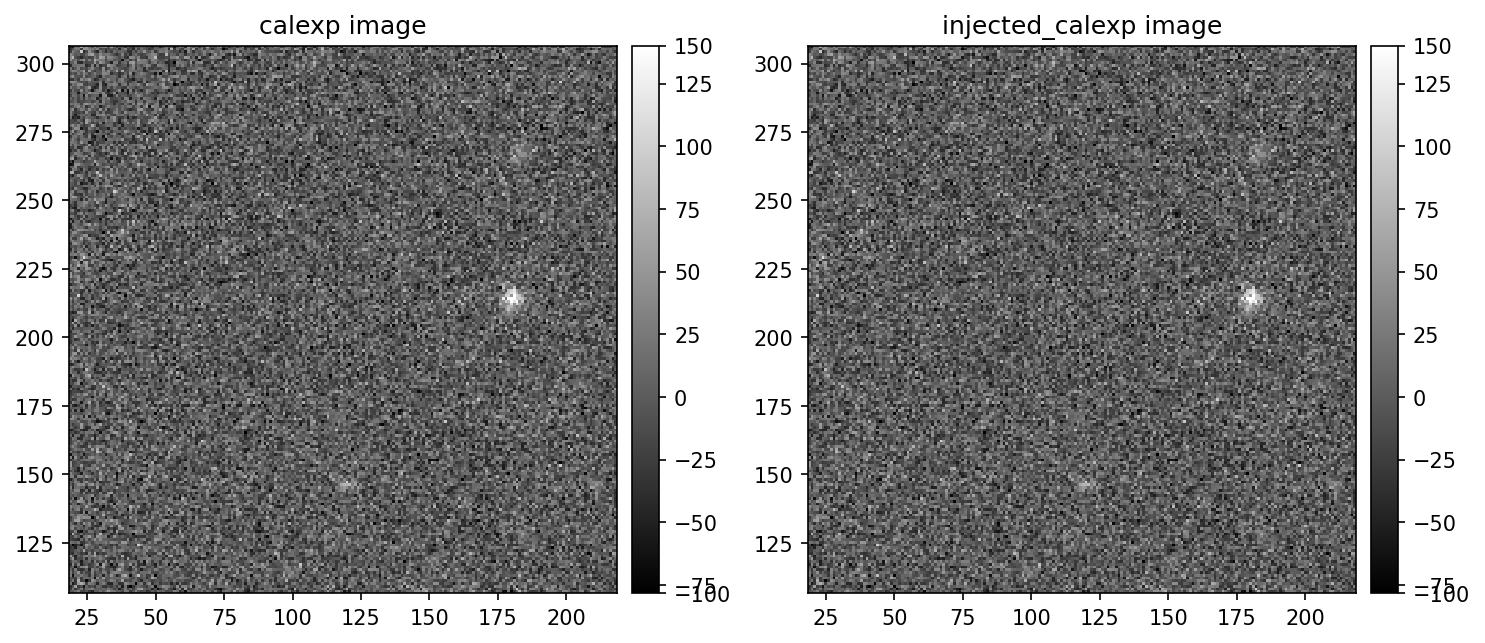

In [46]:
# plot_injected_calexp = injected_exposure.clone()

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(injected_exposure.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(injected_exposure_230.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.tight_layout()
plt.show()

In [46]:
# calexp_butler.get('goodSeeingDiff_templateExp', dataId=dataId)

# DIA for calexp 165, calexp 230

In [47]:
config = AlardLuptonSubtractConfig()
alTask = AlardLuptonSubtractTask(config=config)


sources = calexp_butler.get('src', dataId=dataId)
result = alTask.run(injected_exposure, injected_exposure_230, sources)

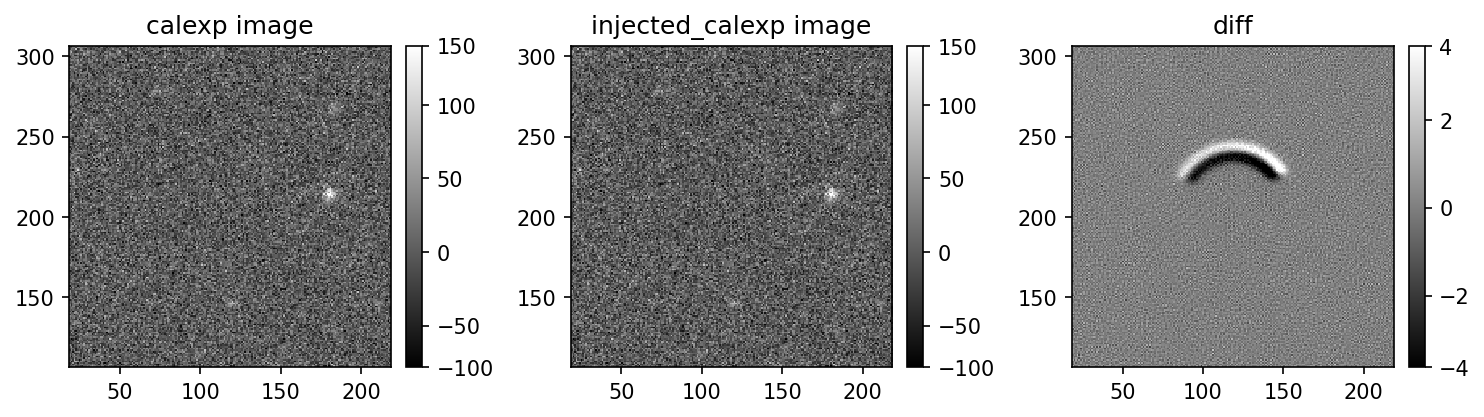

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
# display0.scale('linear', min=-20, max=150)
display0.mtv(injected_exposure.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display1.mtv(plot_injected_calexp.image)
# To zoom on the PGC 038749 stamp:
display1.mtv(injected_exposure_230.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('injected_calexp image')

plt.sca(ax[2])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display1.scale('linear', min=-20, max=150)
# display2.mtv(result.difference.image)
# To zoom on the PGC 038749 stamp:
display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
plt.title('diff')

plt.tight_layout()
plt.show()

# Do source detection

# Injection on same calexp doesn't seem correct. I need the same patch of the sky but at different times. Follow DP02_09_Custom_Coadds/DP02_09a_Custom_Coadd.ipynb, and select the pieces of the coadd